# Evidential MLP Model

In [1]:
import logging, tqdm
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data.dataset import TensorDataset, Dataset
from torch.utils.data.dataloader import DataLoader
import torch.nn.functional as F

import copy
import time, yaml, glob
from collections import defaultdict, OrderedDict

import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from cartopy import crs as ccrs
from cartopy import feature as cfeature

from reliability import reliability_diagram, reliability_diagrams, compute_calibration
from plotting import plot_confusion_matrix
from losses import *
from seed import torch_seed_everything
from metrics import torch_average_acc

/glade/work/jwillson/conda-envs/winter-ptype/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Preprocessing

In [2]:
# load data
dataset = "mPING"
model_name = "mping_071122"
config = f'evidential_config/{model_name}.yml'
with open(config) as f:
    conf = yaml.load(f, Loader=yaml.FullLoader)

df = pd.read_parquet(conf['data_path'])
    
# model config
metric = "torch_average_acc"
metric_fn = torch_average_acc
criterion = edl_mse_loss

features = conf['tempvars'] + conf['tempdewvars'] + conf['ugrdvars'] + conf['vgrdvars']
outputs = conf['outputvars']
n_splits = conf['trainer']['n_splits']
train_size1 = conf['trainer']['train_size1'] # sets test size
train_size2 = conf['trainer']['train_size2'] # sets valid size
seed = conf['trainer']['seed']
epochs = conf['trainer']['epochs']
num_hidden_layers = conf['trainer']['num_hidden_layers']
hidden_size = conf['trainer']['hidden_size']
dropout_rate = conf['trainer']['dropout_rate']
batch_size = conf['trainer']['batch_size']
learning_rate = conf['trainer']['learning_rate']
activation = conf['trainer']['activation']
    
# set seed
torch_seed_everything(seed)
    
# split and preprocess the data
df['day'] = df['datetime'].apply(lambda x: str(x).split(' ')[0])
    
splitter = GroupShuffleSplit(n_splits=n_splits, train_size=train_size1, random_state=seed)
train_idx, test_idx = list(splitter.split(df, groups=df['day']))[0]
train_data, test_data = df.iloc[train_idx], df.iloc[test_idx]
    
splitter = GroupShuffleSplit(n_splits=n_splits, train_size=train_size2, random_state=seed)
train_idx, valid_idx = list(splitter.split(train_data, groups=train_data['day']))[0]
train_data, valid_data = train_data.iloc[train_idx], train_data.iloc[valid_idx]
    
scaler_x = StandardScaler()
x_train = scaler_x.fit_transform(train_data[features])
x_valid = scaler_x.transform(valid_data[features])
x_test = scaler_x.transform(test_data[features])
y_train = np.argmax(train_data[outputs].to_numpy(), 1)
y_valid = np.argmax(valid_data[outputs].to_numpy(), 1)
y_test = np.argmax(test_data[outputs].to_numpy(), 1)

# convert splits to torch tensor datasets
train_split = TensorDataset(
    torch.from_numpy(x_train).float(),
    torch.from_numpy(y_train).long()
)
train_loader = DataLoader(train_split, 
                          batch_size=batch_size, 
                          shuffle=True, 
                          num_workers=0)

valid_split = TensorDataset(
    torch.from_numpy(x_valid).float(),
    torch.from_numpy(y_valid).long()
)
valid_loader = DataLoader(valid_split, 
                          batch_size=batch_size, 
                          shuffle=False, 
                          num_workers=0)

test_split = TensorDataset(
    torch.from_numpy(x_test).float(),
    torch.from_numpy(y_test).long()
)
test_loader = DataLoader(test_split, 
                          batch_size=batch_size, 
                          shuffle=False, 
                          num_workers=0)

dataloaders = {
    "train": train_loader,
    "val": valid_loader,
    "test": test_loader,
}

## Model Structure

In [3]:
def load_mlp_model(input_size, hidden_size, output_size, num_hidden_layers, dropout_rate, activation):
    activation_dict = {'leaky':nn.LeakyReLU(), 'elu':nn.ELU(), 'relu':nn.ReLU() , 'selu':nn.SELU()}
    activation_fn = activation_dict[activation]
    
    model = nn.Sequential()
    model.append(nn.utils.spectral_norm(nn.Linear(input_size, hidden_size)))
    model.append(activation_fn)
    
    for i in range(num_hidden_layers):
        model.append(nn.utils.spectral_norm(nn.Linear(hidden_size, hidden_size)))
        model.append(activation_fn)
   
    model.append(nn.utils.spectral_norm(nn.Linear(hidden_size, output_size)))
    
    return model

model = load_mlp_model(len(features), hidden_size, len(outputs), num_hidden_layers, dropout_rate, activation)

## Model Training

In [4]:
def one_hot_embedding(labels, num_classes=10):
    # Convert to One Hot Encoding
    y = torch.eye(num_classes)
    return y[labels]

def torch_acc(labels, preds):
    return torch.mean((preds == labels.data).float()).item()

def train_model(
    model,
    dataloaders,
    criterion,
    optimizer,
    metric_fn,
    num_classes=4,
    stopping_patience=4,
    minimize=False,
    scheduler=None,
    num_epochs=25,
    device=None,
    uncertainty=False,
    metric="acc"
):

    since = time.time()

    if not device:
        device = get_device()

    best_model_wts = copy.deepcopy(model.state_dict())
    if minimize:
        best_metric = 100.0
    else:  
        best_metric = 0.0

    stop_early = False
    training_results = defaultdict(list)
    for epoch in range(num_epochs):
        # Each epoch has a training and validation phase
        for phase in ["train", "val"]:
            if phase == "train":
                #print("Training...")
                model.train()  # Set model to training mode
            else:
                #print("Validating...")
                model.eval()  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0.0
            correct = 0
            
            if verbose:
                total = int(np.ceil(len(dataloaders[phase].dataset) / batch_size))
                my_iter = tqdm.tqdm(enumerate(dataloaders[phase]),
                                total = total,
                                leave = True)
            else:
                my_iter = enumerate(dataloaders[phase])

            # Iterate over data.
            results_dict = defaultdict(list)
            for i, (inputs, labels) in my_iter:

                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == "train"):

                    if uncertainty:
                        y = one_hot_embedding(labels, num_classes)
                        y = y.to(device)
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(
                            outputs, y.float(), epoch, num_classes, 10, device 
                        )

                        match = torch.reshape(torch.eq(preds, labels).float(), (-1, 1))
                        acc = torch.mean(match)
                        evidence = relu_evidence(outputs)
                        alpha = evidence + 1
                        u = num_classes / torch.sum(alpha, dim=1, keepdim=True)

                        total_evidence = torch.sum(evidence, 1, keepdim=True)
                        mean_evidence = torch.mean(total_evidence)
                        mean_evidence_succ = torch.sum(
                            torch.sum(evidence, 1, keepdim=True) * match
                        ) / torch.sum(match + 1e-20)
                        mean_evidence_fail = torch.sum(
                            torch.sum(evidence, 1, keepdim=True) * (1 - match)
                        ) / (torch.sum(torch.abs(1 - match)) + 1e-20)

                    else:
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                # statistics
                metric_value = metric_fn(labels, preds)
                results_dict["loss"].append(loss.item())
                results_dict[f"{metric}"].append(metric_value)
                
                if verbose:
                    print_str = f"Epoch: {epoch} "
                    print_str += f'{phase}_loss: {np.mean(results_dict["loss"]):.4f} '
                    print_str += f'{phase}_{metric}: {np.mean(results_dict[f"{metric}"]):.4f}'
                    my_iter.set_description(print_str)
                    my_iter.refresh()

            epoch_loss = np.mean(results_dict["loss"])
            epoch_metric = np.mean(results_dict[f"{metric}"])
            
            if phase == "train":
                training_results["train_loss"].append(epoch_loss)
                training_results[f"train_{metric}"].append(epoch_metric)
            else:
                training_results["val_loss"].append(epoch_loss)
                training_results[f"val_{metric}"].append(epoch_metric)
            
            training_results["epoch"].append(epoch)
            
            if scheduler is not None:
                if phase == "val":
                    scheduler.step(1-epoch_metric)

            # deep copy the model
            if phase == "val" and (epoch_metric < best_metric if minimize else epoch_metric > best_metric):
                best_metric = epoch_metric
                best_model_wts = copy.deepcopy(model.state_dict())
                
            # Stop training if we have not improved after X epochs
            if phase == "val":
                best_epoch = [i for i,j in enumerate(
                    training_results[f"val_{metric}"]) if j == max(training_results[f"val_{metric}"])][0]
                offset = epoch - best_epoch
                if offset >= stopping_patience:
                    stop_early = True
                    break
        if stop_early:
            break

    time_elapsed = time.time() - since
    print(
        "Training complete in {:.0f}m {:.0f}s".format(
            time_elapsed // 60, time_elapsed % 60
        )
    )
    print("Best val {}: {:4f}".format(metric, best_metric))

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, optimizer, training_results

In [5]:
device = get_device()
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.005)
verbose= True
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    patience = 2, 
    verbose = verbose,
    min_lr = 1.0e-7
)

model, optimizer, metrics = train_model(
    model,
    dataloaders,
    criterion,
    optimizer,
    metric_fn,
    scheduler=lr_scheduler,
    num_epochs=epochs,
    device=device,
    uncertainty=True,
    metric=metric
)

  0%|          | 0/23 [00:00<?, ?it/s]/glade/u/home/jwillson/winter-ptype/code/losses.py:45: UserWarning: Specified kernel cache directory could not be created! This disables kernel caching. Specified directory is /glade/u/home/jwillson/.cache/torch/kernels. This warning will appear only once per process. (Triggered internally at  /home/conda/feedstock_root/build_artifacts/pytorch-recipe_1654800966673/work/aten/src/ATen/native/cuda/jit_utils.cpp:858.)
  torch.lgamma(sum_alpha)
Epoch: 0 train_loss: 0.5319 train_torch_average_acc: 0.4390: 100%|██████████| 23/23 [00:08<00:00,  2.58it/s]
Epoch: 0 val_loss: 0.3006 val_torch_average_acc: 0.4573: 100%|██████████| 3/3 [00:00<00:00,  4.41it/s]
Epoch: 1 train_loss: 0.3430 train_torch_average_acc: 0.4626: 100%|██████████| 23/23 [00:07<00:00,  3.00it/s]
Epoch: 1 val_loss: 0.2779 val_torch_average_acc: 0.4660: 100%|██████████| 3/3 [00:00<00:00,  4.41it/s]
Epoch: 2 train_loss: 0.3374 train_torch_average_acc: 0.4693: 100%|██████████| 23/23 [00:07<00:

Epoch 00030: reducing learning rate of group 0 to 5.4185e-06.


Epoch: 30 train_loss: 0.3424 train_torch_average_acc: 0.6411: 100%|██████████| 23/23 [00:07<00:00,  2.98it/s]
Epoch: 30 val_loss: 0.3127 val_torch_average_acc: 0.5957: 100%|██████████| 3/3 [00:00<00:00,  4.38it/s]

Training complete in 4m 23s
Best val torch_average_acc: 0.612622


### Save Model

In [16]:
torch.save(model.state_dict(), f'/glade/work/jwillson/{model_name}.pt')

## Model Evaluation

### Load Saved Model (build model structure first)

In [ ]:
model = torch.load(f'/glade/work/jwillson/{model_name}.pt')

### Test Model

In [6]:
def test_model(
    test_loader,
    metric_fn,
    metric="acc",
    num_classes=4,
    verbose=True,
    use_uncertainty=True
):
    model.eval()
    with torch.no_grad():

        if verbose:
            total = int(np.ceil(len(test_loader.dataset) / batch_size))
            my_iter = tqdm.tqdm(enumerate(test_loader),
                            total = total,
                            leave = True)
        else:
            my_iter = enumerate(test_loader)

        # Iterate over data.
        results_dict = defaultdict(list)
        for i, (inputs, labels) in my_iter:

            inputs = inputs.to(device)
            labels = labels.to(device)

            if use_uncertainty:
                output = model(inputs)
                evidence = relu_evidence(output)
                alpha = evidence + 1
                uncertainty = num_classes / torch.sum(alpha, dim=1, keepdim=True)
                _, preds = torch.max(output, 1)
                prob = alpha / torch.sum(alpha, dim=1, keepdim=True)
                results_dict["pred_uncertainty"].append(uncertainty)

            else:
                output = model(img_variable)
                _, preds = torch.max(output, 1)
                prob = F.softmax(output, dim=1)

            results_dict["pred_labels"].append(preds.unsqueeze(-1))
            results_dict["true_labels"].append(labels.unsqueeze(-1))
            results_dict["pred_probs"].append(prob)

            # statistics
            metric_value = metric_fn(labels, preds)
            results_dict[f"{metric}"].append(metric_value)

            if verbose:
                print_str = f'test_{metric}: {np.mean(results_dict[f"{metric}"]):.4f}'
                my_iter.set_description(print_str)
                my_iter.refresh()

        results_dict["pred_uncertainty"] = torch.cat(results_dict["pred_uncertainty"], 0)
        results_dict["pred_probs"] = torch.cat(results_dict["pred_probs"], 0)
        results_dict["pred_labels"] = torch.cat(results_dict["pred_labels"], 0)
        results_dict["true_labels"] = torch.cat(results_dict["true_labels"], 0)
    
        return results_dict
    
results_dict = test_model(dataloaders['test'], metric_fn, metric=metric)

test_torch_average_acc: 0.6573: 100%|██████████| 3/3 [00:00<00:00,  4.58it/s]


## Visualize Model Results

### Convert Torch Tensors to NumPy 

In [7]:
uncertainties = results_dict["pred_uncertainty"][:, 0].cpu().numpy()
preds = results_dict["pred_labels"][:, 0].cpu().numpy()
labels = results_dict["true_labels"][:, 0].cpu().numpy()
probs = np.max(results_dict["pred_probs"].cpu().numpy(), 1)

### Confusion Matrices

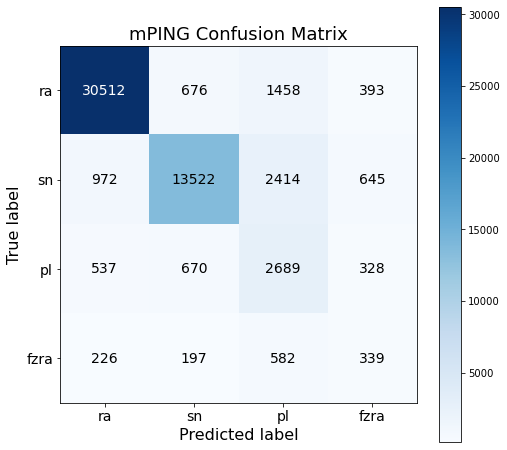

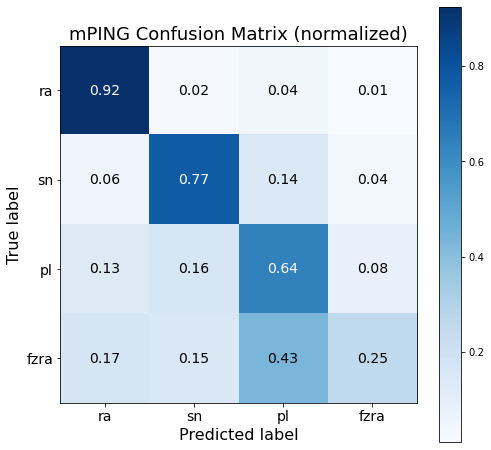

In [8]:
np.set_printoptions(precision=2)
class_names = ['ra', 'sn', 'pl', 'fzra']

# Plot non-normalized confusion matrix
plot_confusion_matrix(labels, preds, classes=class_names,
                      title=f'{dataset} Confusion Matrix', filename=f'{model_name}.png')

# Plot normalized confusion matrix
plot_confusion_matrix(labels, preds, classes=class_names, normalize=True,
                      title=f'{dataset} Confusion Matrix (normalized)', filename=f'{model_name}_norm.png')

plt.show()

### Reliability Diagrams

In [9]:
test_data = pd.DataFrame.from_dict(
        {"pred_labels": preds,
    "true_labels": labels, 
    "pred_conf": probs,
    "uncertainty": uncertainties})

/glade/u/home/jwillson/winter-ptype/code/reliability.py:175: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(new_ticks)


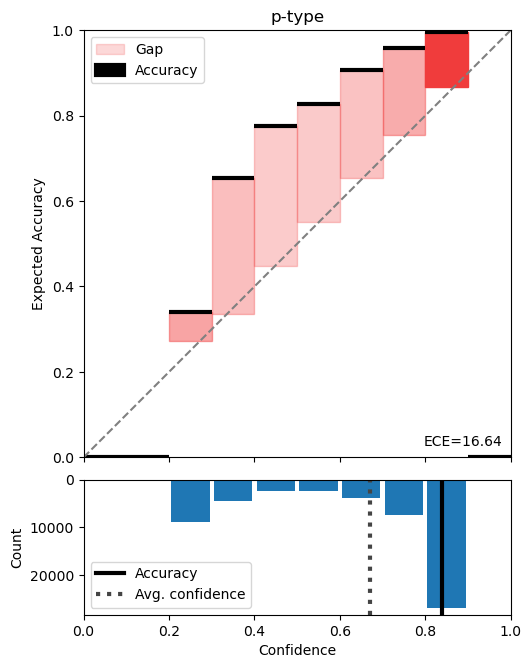

In [10]:
title = f"{dataset} Reliability Diagram"
fig = reliability_diagram(
    test_data["true_labels"].to_numpy(),
    test_data["pred_labels"].to_numpy(),
    test_data["pred_conf"].to_numpy(),
    num_bins=10, draw_ece=True,
    draw_bin_importance="alpha", draw_averages=True,
    title=title, figsize=(5, 5), dpi=100,
    return_fig=True)

plt.savefig(conf['image_path']+f'/{model_name}_reliability.png', dpi=300, bbox_inches='tight')
plt.show()

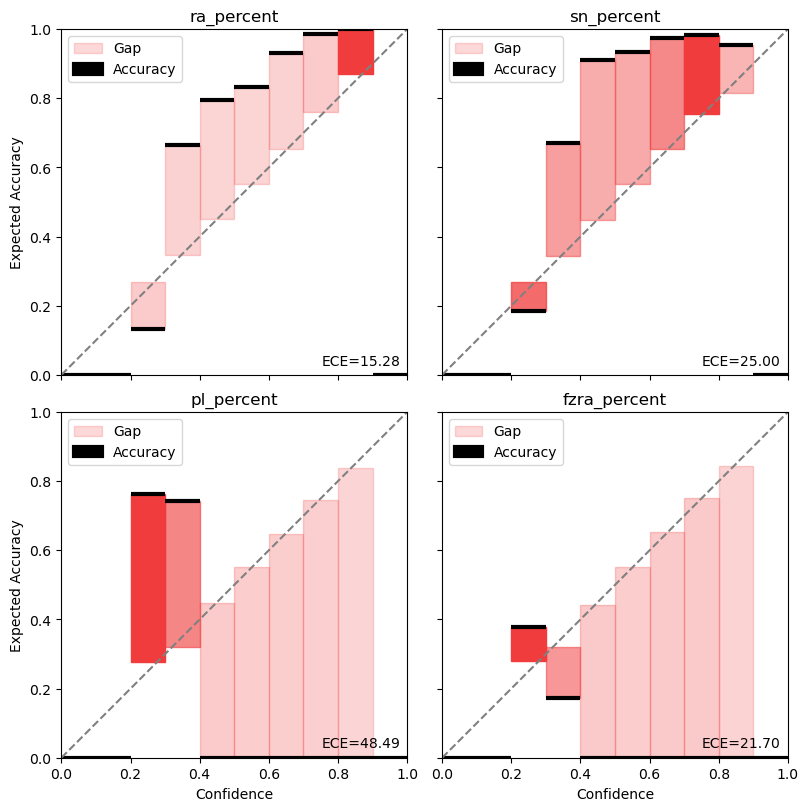

In [11]:
cond0 = (test_data["true_labels"] == 0)
cond1 = (test_data["true_labels"] == 1)
cond2 = (test_data["true_labels"] == 2)
cond3 = (test_data["true_labels"] == 3)
results = OrderedDict()
results[outputs[0]] = {
    "true_labels": test_data[cond0]["true_labels"].values,
    "pred_labels": test_data[cond0]["pred_labels"].values,
    "confidences": test_data[cond0]["pred_conf"].values
}
results[outputs[1]] = {
    "true_labels": test_data[cond1]["true_labels"].values,
    "pred_labels": test_data[cond1]["pred_labels"].values,
    "confidences": test_data[cond1]["pred_conf"].values
}
results[outputs[2]] = {
    "true_labels": test_data[cond2]["true_labels"].values,
    "pred_labels": test_data[cond2]["pred_labels"].values,
    "confidences": test_data[cond2]["pred_conf"].values
}
results[outputs[3]] = {
    "true_labels": test_data[cond3]["true_labels"].values,
    "pred_labels": test_data[cond3]["pred_labels"].values,
    "confidences": test_data[cond3]["pred_conf"].values
}
fig = reliability_diagrams(results, num_bins=10, draw_bin_importance="alpha", num_cols=2, dpi=100, return_fig=True)
plt.savefig(conf['image_path']+f'/{model_name}_class_reliability.png', dpi=300, bbox_inches='tight')
plt.show()

### Cumulative Accuracy Trends

/glade/scratch/jwillson/ipykernel_94706/3745878744.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([1.2, 1.0, 0.8, 0.6, 0.4, 0.2, 0.0])


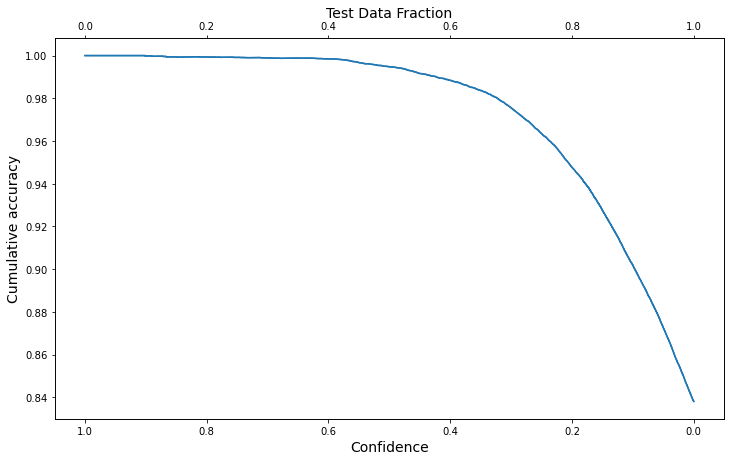

In [12]:
def compute_cov(df, col = "pred_conf", quan = "uncertainty", ascending = False):
    df = df.copy()
    df = df.sort_values(col, ascending = ascending)
    df["dummy"] = 1
    df[f"cu_{quan}"] = df[quan].cumsum() / df["dummy"].cumsum()
    df[f"cu_{col}"] = df[col].cumsum() / df["dummy"].cumsum()
    df[f"{col}_cov"] = df["dummy"].cumsum() / len(df)
    return df

test_data["acc"] = (test_data["pred_labels"] == test_data["true_labels"]).to_numpy()
test_data_sorted = compute_cov(test_data, col = "pred_conf", quan = "acc")

fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(1, 1, 1)
ax.plot(
    test_data_sorted["pred_conf_cov"],
    test_data_sorted["cu_acc"]
)
ax.set_xticklabels([1.2, 1.0, 0.8, 0.6, 0.4, 0.2, 0.0])

ax2 = ax.twiny()
ax2.set_xlabel("Test Data Fraction", fontsize=14)
ax2.plot(
    test_data_sorted["pred_conf_cov"],
    test_data_sorted["cu_acc"]
)
ax.set_ylabel("Cumulative Accuracy", fontsize=14)
ax.set_xlabel("Confidence", fontsize=14)

plt.savefig(conf['image_path']+f'/{model_name}_acc_vs_cov.png', dpi=300, bbox_inches='tight')
plt.show()

/glade/scratch/jwillson/ipykernel_94706/3575419412.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([1.2, 1.0, 0.8, 0.6, 0.4, 0.2, 0.0])


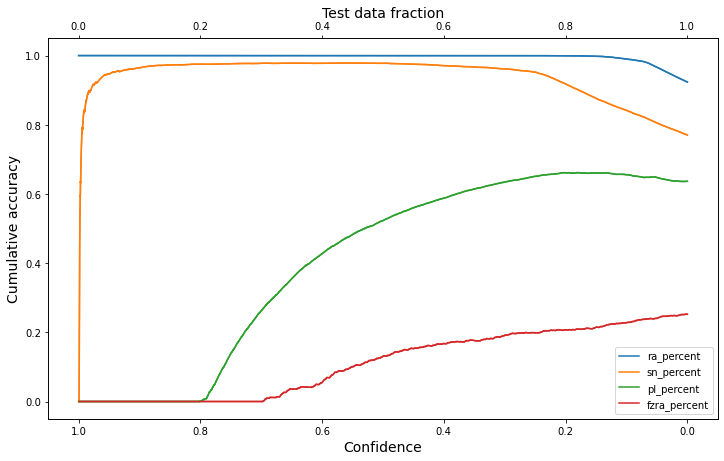

In [13]:
fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(1, 1, 1)
ax2 = ax.twiny()
for c in [cond0, cond1, cond2, cond3]:
    _test_data_sorted = compute_cov(test_data[c], col = "pred_conf", quan = "acc")
    ax.plot(
        _test_data_sorted["pred_conf_cov"],
        _test_data_sorted["cu_acc"]
    )
    ax2.plot(
        _test_data_sorted["pred_conf_cov"],
        _test_data_sorted["cu_acc"]
    )

ax.set_xticklabels([1.2, 1.0, 0.8, 0.6, 0.4, 0.2, 0.0])
ax.set_ylabel("Cumulative Accuracy", fontsize=14)
ax2.set_xlabel("Test Data Fraction", fontsize=14)
ax.set_xlabel("Confidence", fontsize=14)
ax.legend(outputs)
plt.savefig(conf['image_path']+f'/{model_name}_class_acc_vs_cov.png', dpi=300, bbox_inches='tight')
plt.show()

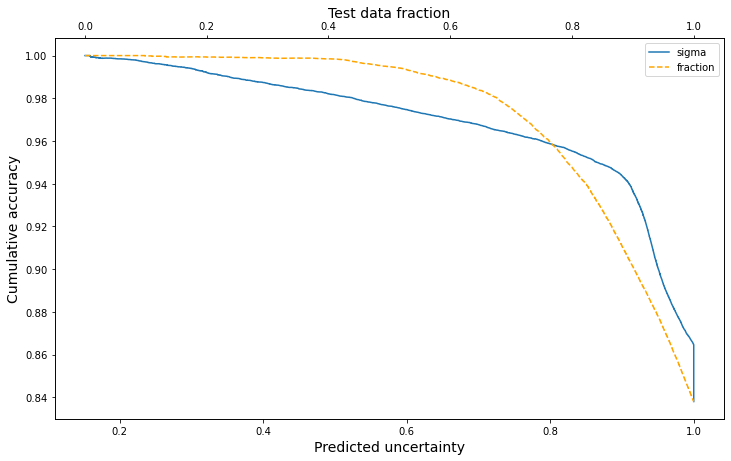

In [14]:
fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(1, 1, 1)

test_data_sorted = compute_cov(test_data, col = "uncertainty", quan = "acc", ascending = True)

l1, = ax.plot(
    test_data_sorted["uncertainty"],
    test_data_sorted["cu_acc"],
    label = "sigma"
)

ax2 = ax.twiny()
l2, = ax2.plot(
    test_data_sorted["uncertainty_cov"],
    test_data_sorted["cu_acc"], 
    color='orange', ls = "--", 
    label = "fraction")

ax.set_ylabel("Cumulative Accuracy", fontsize=14)
ax2.set_xlabel("Test Data Fraction", fontsize=14)
ax.set_xlabel("Predicted Uncertainty", fontsize=14)

plt.legend([l1, l2], ["sigma", "fraction"])
plt.savefig(conf['image_path']+f'/{model_name}_acc_vs_unc.png', dpi=300, bbox_inches='tight')
plt.show()

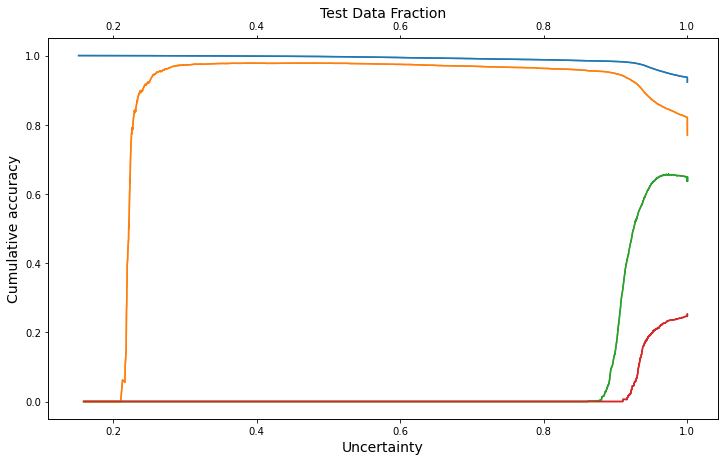

In [15]:
fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(1, 1, 1)
ax2 = ax.twiny()
for c in [cond0, cond1, cond2, cond3]:
    _test_data_sorted = compute_cov(test_data[c], col = "uncertainty", quan = "acc", ascending = True)
    ax.plot(
        _test_data_sorted["uncertainty"],
        _test_data_sorted["cu_acc"]
    )
    ax2.plot(
        _test_data_sorted["uncertainty"],
        _test_data_sorted["cu_acc"]
    )
    
ax.set_ylabel("Cumulative Accuracy", fontsize=14)
ax2.set_xlabel("Test Data Fraction", fontsize=14)
ax.set_xlabel("Uncertainty", fontsize=14)
plt.savefig(conf['image_path']+f'/{model_name}_class_acc_vs_unc.png', dpi=300, bbox_inches='tight')
plt.show()

## Case Studies